## ドイチ-ジョサのアルゴリズム

qiskitを利用して、量子アルゴリズムについて自分なりに勉強していこうと思います。
個人的な勉強の記録なので、説明などを大幅に省いている可能性があります。

qiskitのウェブサイト通りに勉強を進めています。

- https://qiskit.org/textbook/ja/ch-algorithms/deutsch-jozsa.html

今回は、ドイチ-ジョサのアルゴリズムを数式を追って理解を深めようと思います。

私の勉強不足ですが、学生時代、量子情報を勉強した際はドイチ-ジョサのアルゴリズムというのは知りませんでした。ショアのアルゴリズムなどと比較すると有名ではないのかもしれませんが、qiskitのサイトに寄ると、古典アルゴリズムよりも優れたパフォーマンスを持つと発表された最初の量子アルゴリズムという事で、理解は必須のような気がしています。

### github
- jupyter notebook形式のファイルは[こちら](https://github.com/hiroshi0530/wa-src/blob/master/rec/qiskit/base3/base_nb.ipynb)

### google colaboratory
- google colaboratory で実行する場合は[こちら](https://colab.research.google.com/github/hiroshi0530/wa-src/blob/master/rec/qiskit/base3/base_nb.ipynb)

### 筆者の環境

In [36]:
!sw_vers

ProductName:	Mac OS X
ProductVersion:	10.14.6
BuildVersion:	18G103


In [37]:
!python -V

Python 3.8.5


基本的なライブラリをインポートしそのバージョンを確認しておきます。

In [18]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd

print('matplotlib version :', matplotlib.__version__)
print('scipy version :', scipy.__version__)
print('numpy version :', np.__version__)
print('pandas version :', pd.__version__)

matplotlib version : 3.3.2
scipy version : 1.5.2
numpy version : 1.19.2
pandas version : 1.1.3


In [19]:
import qiskit
import json

dict(qiskit.__qiskit_version__)

{'qiskit-terra': '0.17.4',
 'qiskit-aer': '0.8.2',
 'qiskit-ignis': '0.6.0',
 'qiskit-ibmq-provider': '0.13.1',
 'qiskit-aqua': '0.9.1',
 'qiskit': '0.26.2',
 'qiskit-nature': None,
 'qiskit-finance': None,
 'qiskit-optimization': None,
 'qiskit-machine-learning': None}

In [25]:
from qiskit import IBMQ, Aer, execute
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile

from qiskit.visualization import plot_histogram
from qiskit_textbook.tools import array_to_latex

## 問題設定

ドイチ-ジョサ問題はビット列を入力として、0か1を返すと、いう関数を考え、その関数が、定数型か、分布型に限定される場合、どちらの型の関数を決定する問題になります。定数型の場合は、どのような入力でも0か1のどちらかを返し、分布型の場合は、半分の入力に対して0を返し、残りの半分の入力に対しては1を返します。

簡単に考えると、1回目の試行で0が出て、2回目の試行で1が出れば分布型であると分かりますが、2回目も0の場合、決定することが出来ずに再度試行を重ねることになります。

量子コンピュータを利用して、ドイチ-ジョサアルゴリズムを適用すると、$f(x)$を一度実行させるだけでどちらの型かを決定することが出来るというものです。

こちらもqiskitの[サイト](https://qiskit.org/textbook/ja/ch-algorithms/deutsch-jozsa.html)に沿って手を動かしてみようと思います。

アルゴリズムの流れは以下の様なフローになります。これも上記サイトを書き写しただけです。

![svg](base_nb_files_local/dj.svg)

### 1.  量子ビットの準備

$|0\rangle$に初期化された量子ビットを$N$個と$|1\rangle$に初期化された量子ビットを1つ用意します。

$$
\left|\psi_{0}\right\rangle=|0\rangle^{\otimes n}|1\rangle
$$

### 2. アダマールゲートを適用

全量子ビットにアダマールゲートを適用します。

$$
\left|\psi_{1}\right\rangle=\frac{1}{\sqrt{2^{n+1}}} \sum_{x=0}^{2^{n}-1}|x\rangle(|0\rangle-|1\rangle)
$$

以下の公式を利用します。

$$
\begin{aligned}
&|0\rangle \stackrel{H}{\longrightarrow} \frac{1}{\sqrt{2}}(|0\rangle+|1\rangle) \\
&|1\rangle \stackrel{H}{\longrightarrow} \frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)
\end{aligned}
$$

ここで言う、$|x\rangle$は、2ビット表記で以下の様な状態を表します。$x_k$は0か1です。詳細な具体例は[こちら](#ビット表記)です。

$$
|x\rangle=\left|x_{n} x_{n-1} \cdots x_{2} x_{1} x_{0}\right\rangle
$$

### 3. 量子オラクルの適用

$|x\rangle|y\rangle=|x_{n} x_{n-1} \cdots x_{2} x_{1} x_{0}\rangle|y\rangle$を$|x\rangle|y \oplus f(x)\rangle$に変換する量子オラクルを適用すると、$f(x)$の部分を係数（グローバル位相）に外出しすることが出来ます。

$$
\begin{aligned}
\left|\psi_{2}\right\rangle &=\frac{1}{\sqrt{2^{n+1}}} \sum_{x=0}^{2^{n}-1}|x\rangle(|f(x)\rangle-|1 \oplus f(x)\rangle) \\
&=\frac{1}{\sqrt{2^{n+1}}} \sum_{x=0}^{2^{n}-1}(-1)^{f(x)}|x\rangle(|0\rangle-|1\rangle)
\end{aligned}
$$



### 4. 最初のNビットにアダマールゲートを適用

ここで、最後の量子ビット$\displaystyle \frac{1}{\sqrt{2}}(|0\rangle - |1\rangle)$を無視すると、

$$
\begin{aligned}
\left|\psi_{3}\right\rangle &=\frac{1}{2^{n}} \sum_{x=0}^{2^{n}-1}(-1)^{f(x)}\left[\sum_{y=0}^{2^{n}-1}(-1)^{x \cdot y}|y\rangle\right] \\
&=\frac{1}{2^{n}} \sum_{y=0}^{2^{n}-1}\left[\sum_{x=0}^{2^{n}-1}(-1)^{f(x)}(-1)^{x \cdot y}\right]|y\rangle
\end{aligned}
$$

となります。$x \cdot y=x_{0} y_{0} \oplus x_{1} y_{1} \oplus \ldots \oplus x_{n-1} y_{n-1}$はビット単位の積の和です。

### 5. 最初のNビットを測定

最初のNビットの$\displaystyle |0\rangle^{\otimes n}$の振幅確率を計算します。

$$
\left|\frac{1}{2^{n}} \sum_{x=0}^{2^{n}-1}(-1)^{f(x)}\right|^{2}
$$

この結果が、$f(x)$が定数型の場合は1で、$f(x)$が分布型の場合は0になります。

## 2ビットの分布型の関数の例

サイトのコピーですが、少しずつ理解しながら進めます。

### 1. 量子ビットの初期化

$$
\left|\psi_{0}\right\rangle=|00\rangle_{12} \otimes|1\rangle_{3}
$$

### 2. 全量子ビットにアダマールゲートを適用

$$
\left|\psi_{1}\right\rangle=\frac{1}{2}(|00\rangle+|01\rangle+|10\rangle+|11\rangle)_{12} \otimes \frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)_{3}
$$

### 3. オラクル関数の実装
分布型の関数の場合、オラクル関数は位相キックバックを利用し、CXゲートで実装する事が出来ます。制御ビットが0ならば何もせず、1ならば位相を反転させる操作なので、CXゲートが利用できます。

$$
\begin{aligned}
\left|\psi_{2}\right\rangle &=\frac{1}{2 \sqrt{2}}\left[|00\rangle_{12} \otimes(|0 \oplus 0 \oplus 0\rangle-|1 \oplus 0 \oplus 0\rangle)_{3}\right.\\
&+|01\rangle_{12} \otimes(|0 \oplus 0 \oplus 1\rangle-|1 \oplus 0 \oplus 1\rangle)_{3} \\
&+|10\rangle_{12} \otimes(|0 \oplus 1 \oplus 0\rangle-|1 \oplus 1 \oplus 0\rangle)_{3} \\
&\left.+|11\rangle_{12} \otimes(|0 \oplus 1 \oplus 1\rangle-|1 \oplus 1 \oplus 1\rangle)_{3}\right]
\end{aligned}
$$

### 4. 式の整理

$$
\begin{aligned}
\left|\psi_{2}\right\rangle &=\frac{1}{2 \sqrt{2}}\left[|00\rangle_{12} \otimes(|0\rangle-|1\rangle)_{3}-|01\rangle_{12} \otimes(|0\rangle-|1\rangle)_{3}-|10\rangle_{12} \otimes(|0\rangle-|1\rangle)_{3}+|11\rangle_{12} \otimes(|0\rangle-|1\rangle)_{3}\right] \\
&=\frac{1}{2}(|00\rangle-|01\rangle-|10\rangle+|11\rangle)_{12} \otimes \frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)_{3} \\
&=\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)_{1} \otimes \frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)_{2} \otimes \frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)_{3}
\end{aligned}
$$

非常にシンプルになりました。

### 5. 最初の量子ビットにアダマールゲートを適用

$$
\left|\psi_{3}\right\rangle=|1\rangle_{1} \otimes|1\rangle_{2} \otimes(|0\rangle-|1\rangle)_{3}
$$

### 6. 最初の2量子ビットを測定

最初の2量子ビットを測定すると、$|11\rangle$が得られ、分布が関数という事が分かります。

## 複数ビットへのアダマールゲートを適用した際の表記

複数量子ビットへのアダマールゲートの演算に関して公式みたいなのがさらって出てきたので、簡単に実際に計算して確認してみます。

$$
\left|x\right\rangle \stackrel{H}{\rightarrow} \frac{1}{\sqrt{2^n}}\left(\sum_{y=0}^{2^{n}-1}(-1)^{x \cdot y}|y\rangle\right)
$$

ただし、$x \cdot y$はビット単位の積の和です。

$$
x \cdot y=x_{0} y_{0} \oplus x_{1} y_{1} \oplus \ldots \oplus x_{n-1} y_{n-1}
$$


### ビット表記

よくあるのですが、以下の様なシグマ記号を見ると、$|3\rangle$というのが出てくるのですが、これはビット表記に頭の中で変換する必要があります。

$$
\sum_{y=0}^{2^{n}-1}(-1)^{x \cdot y}|y\rangle
$$

ブラ記号の中に$x$が含まれる場合、以下の様な量子状態を意味します。

$$
|x\rangle = |x_nx_{n-1} \cdots x_2x_1x_0 \rangle
$$

$x_k$は0か1だけです。3量子ビットの具体的な表記としては以下の様になります。

$$
\begin{aligned}
&|0\rangle=|000\rangle \\
&|1\rangle=|001\rangle \\
&|2\rangle=|010\rangle \\
&|3\rangle=|011\rangle \\
&|4\rangle=|100\rangle \\
&|5\rangle=|101\rangle \\
&|6\rangle=|110\rangle \\
&|7\rangle=|111\rangle 
\end{aligned}
$$


### 確認


まず、１ビットから。

$$
\begin{aligned}
&|0\rangle \stackrel{H}{\rightarrow} \frac{1}{\sqrt{2}} \sum_{y=0}^{1}(-1)^{0 \cdot y}|y\rangle=\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle) \\
&|1\rangle \stackrel{H}{\rightarrow} \frac{1}{\sqrt{2}} \sum_{y=0}^{1}(-1)^{1 \cdot y}|y\rangle=\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)
\end{aligned}
$$

１ビットはわかりやすいので、２ビットについても手計算してみます。答え合わせのためにqiskitも利用します。

まずは、$|00\rangle$からです。

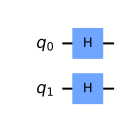

In [49]:
qc = QuantumCircuit(2)
qc.h(0)
qc.h(1)
qc.draw('mpl')

In [50]:
backend = Aer.get_backend('statevector_simulator')
final_state = execute(qc,backend).result().get_statevector()
array_to_latex(final_state, pretext="\\text{Statevector} = ")

<IPython.core.display.Math object>

手計算してみます。

$$
\begin{aligned}
\mid 00) & \stackrel{H}{\rightarrow} \frac{1}{\sqrt{2^2}} \sum_{y=0}^{3}(-1)^{x \cdot y}|y\rangle \\
&=\frac{1}{\sqrt{2^{2}}} \sum_{y=0}^{3}(-1)^{x_{0} y_{0}+x_{1}, y_{1}}|y\rangle \\
&=\frac{1}{\sqrt{2^{2}}} \sum_{y=0}^{3}|y\rangle \\
&=\frac{1}{\sqrt{2^{2}}} \left(|00\rangle+|01\rangle+|10\rangle+|11\rangle\right)
\end{aligned}
$$

となり、一致していることが分かります。

$|01\rangle$です。

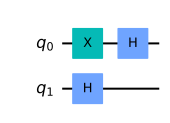

In [57]:
qc = QuantumCircuit(2)
qc.x(0)
qc.h(0)
# qc.x(1)
qc.h(1)
qc.draw('mpl')

In [58]:
backend = Aer.get_backend('statevector_simulator')
final_state = execute(qc,backend).result().get_statevector()
array_to_latex(final_state, pretext="\\text{Statevector} = ")

<IPython.core.display.Math object>

$$
\begin{aligned}
\mid 01) & \stackrel{H}{\rightarrow} \frac{1}{\sqrt{2^2}} \sum_{y=0}^{3}(-1)^{x \cdot y}|y\rangle \\
&=\frac{1}{\sqrt{2^{2}}} \sum_{y=0}^{3}(-1)^{x_{0} y_{0}+x_{1}, y_{1}}|y\rangle \\
&=\frac{1}{\sqrt{2^{2}}} \sum_{y=0}^{3}(-1)^{y_{0}}|y\rangle \\
&=\frac{1}{\sqrt{2^{2}}} \left(|00\rangle-|01\rangle+|10\rangle-|11\rangle\right)
\end{aligned}
$$
となり、こちらも一致しています。


$|10\rangle$です。

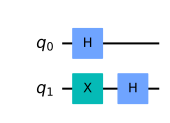

In [59]:
qc = QuantumCircuit(2)
qc.x(1)
qc.h(0)
qc.h(1)
qc.draw('mpl')

In [60]:
backend = Aer.get_backend('statevector_simulator')
final_state = execute(qc,backend).result().get_statevector()
array_to_latex(final_state, pretext="\\text{Statevector} = ")

<IPython.core.display.Math object>

$$
\begin{aligned}
\mid 10) & \stackrel{H}{\rightarrow} \frac{1}{\sqrt{2^2}} \sum_{y=0}^{3}(-1)^{x \cdot y}|y\rangle \\
&=\frac{1}{\sqrt{2^{2}}} \sum_{y=0}^{3}(-1)^{x_{0} y_{0}+x_{1}, y_{1}}|y\rangle \\
&=\frac{1}{\sqrt{2^{2}}} \sum_{y=0}^{3}(-1)^{y_{1}}|y\rangle \\
&=\frac{1}{\sqrt{2^{2}}} \left(|00\rangle+|01\rangle-|10\rangle-|11\rangle\right)
\end{aligned}
$$


$|11\rangle$です。

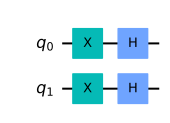

In [61]:
qc = QuantumCircuit(2)
qc.x(0)
qc.h(0)
qc.x(1)
qc.h(1)
qc.draw('mpl')

In [56]:
backend = Aer.get_backend('statevector_simulator')
final_state = execute(qc,backend).result().get_statevector()
array_to_latex(final_state, pretext="\\text{Statevector} = ")

<IPython.core.display.Math object>

$$
\begin{aligned}
\mid 11) & \stackrel{H}{\rightarrow} \frac{1}{\sqrt{2^2}} \sum_{y=0}^{3}(-1)^{x \cdot y}|y\rangle \\
&=\frac{1}{\sqrt{2^{2}}} \sum_{y=0}^{3}(-1)^{x_{0} y_{0}+x_{1}, y_{1}}|y\rangle \\
&=\frac{1}{\sqrt{2^{2}}} \sum_{y=0}^{3}(-1)^{y_{0} + y_{1}}|y\rangle \\
&=\frac{1}{\sqrt{2^{2}}} \left(|00\rangle-|01\rangle-|10\rangle+|11\rangle\right)
\end{aligned}
$$

となりこちらも一致しています。簡単にですが、braの中のビット表記とか少しややこしいですが、慣れるとそうでもないですね。

## 量子オラクルの作成

量子オラクルを実際に量子回路として作成する方法が解説されています。

量子オラクル$f(x)$は以下の様な回路にになります。

$$
|x\rangle|y\rangle \rightarrow |x\rangle|y \oplus f(x)\rangle
$$

よって、$f(x)$が定数型、分布型で分けた場合、簡単に表記できます。

### 定数型関数の場合

1. $f(x)=0$の場合、$|x\rangle|y \oplus f(x)\rangle$より、レジスタ2の量子ビットに何も操作する必要がないので、$I$ゲートを適用します。

2. $f(x)=1$の場合、$X$ゲートを適用すれば良い事になります。

### 分布型の場合

上記で述べたように、レジスター1の各量子ビットを制御ビット、レジスター2の量子ビットをターゲットにしてCXゲートを適用すれば良い事になります。

こんなアルゴリズムを考える人はすごいです。
次はサイモンのアルゴリズムを勉強しようと思います。